In [40]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from pyod.models.lof import LOF
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from faker import Faker

In [41]:
import random 
random.seed(3) 

fake = Faker()
Faker.seed(4321)
names_list = []
size=2000

fake = Faker()
for _ in range(size):
    names_list.append(fake.name())
    
salaries = []
for _ in range(size):
    salary = random.randint(500,2500)
    salaries.append(salary)
    
expenses = []
for _ in range(size):
    expense = random.randint(600,1500)
    expenses.append(expense)    

In [42]:
# Create pandas DataFrame
salary_df = pd.DataFrame(
    {'Person': names_list,
     'Salary': salaries, 
     'Expenses': expenses
    })

salary_df.head()

,Person,Salary,Expenses
0,Jason Brown,987,1215
1,Jacob Stein,1713,1389
2,Cody Brown,1614,1340
3,Larry Morales,767,952
4,Jessica Hendricks,1257,1482


In [43]:
indices=[]
values=[]
for i in range(int(0.05*size)):
    ind=random.randint(0,200)
    indices.append(ind)
    value=random.randint(300,350)
    values.append(value)
    salary_df.at[ind, 'Salary'] = value

In [44]:
#for i in indices:
 #   print(salary_df.loc[i])

In [45]:
salary_df['Anomaly']=0

for ind in indices:
    salary_df.at[ind, 'Anomaly'] = 1

In [46]:
func = lambda x: round(100*x.count()/salary_df.shape[0],1)
salary_distribution=salary_df.pivot_table(index='Anomaly', values='Person', aggfunc=func, margins=True)
salary_distribution.columns=['% Total']
salary_distribution

,% Total
Anomaly,
0,96.0
1,4.0
All,100.0


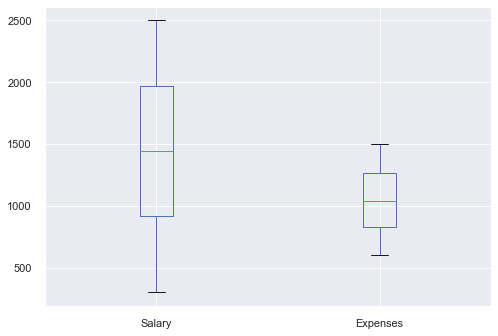

In [47]:
salary_df[['Salary', 'Expenses']].plot(kind='box')
plt.show()

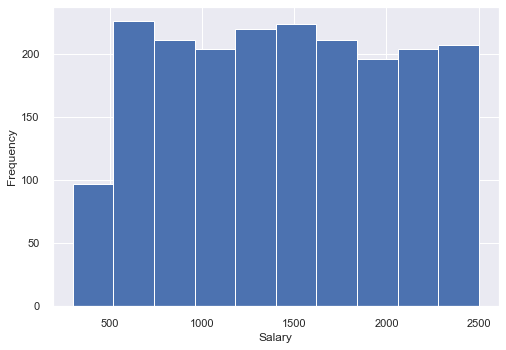

In [48]:
ax = salary_df['Salary'].plot(kind='hist')
ax.set_xlabel('Salary')
plt.show()

In [49]:
print('Minimum salary ' + str(salary_df['Salary'].min()))
print('Maximum salary ' + str(salary_df['Salary'].max()))

Minimum salary 300
Maximum salary 2500


In [50]:
from sklearn.cluster import KMeans

In [51]:
salary_df.head()

,Person,Salary,Expenses,Anomaly
0,Jason Brown,987,1215,0
1,Jacob Stein,1713,1389,0
2,Cody Brown,328,1340,1
3,Larry Morales,767,952,0
4,Jessica Hendricks,314,1482,1


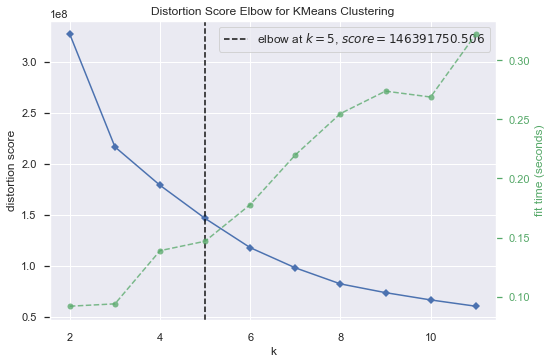

In [52]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(salary_df[['Salary', 'Expenses']])        
visualizer.show()    
plt.show()

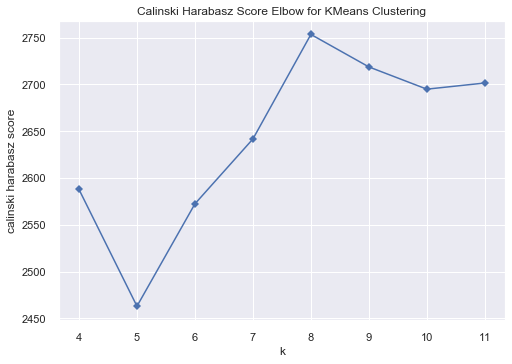

In [53]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,12), metric='calinski_harabasz', timings=False, locate_elbow=False
)

visualizer.fit(salary_df[['Salary', 'Expenses']])        # Fit the data to the visualizer
visualizer.show()   
plt.show()

In [58]:
Clusters=KMeans(6, random_state=0).fit(salary_df[['Salary','Expenses']])

In [59]:
salary_df['cluster']=Clusters.labels_
salary_df.head()

,Person,Salary,Expenses,Anomaly,cluster
0,Jason Brown,987,1215,0,5
1,Jacob Stein,1713,1389,0,2
2,Cody Brown,328,1340,1,3
3,Larry Morales,767,952,0,1
4,Jessica Hendricks,314,1482,1,3


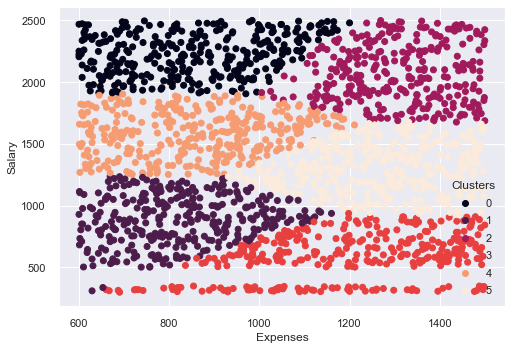

In [60]:
sns.set()
fig, ax = plt.subplots()
scatter = ax.scatter(salary_df['Expenses'], salary_df['Salary'], c=salary_df['cluster'])

legend1 = ax.legend(*scatter.legend_elements(), loc="lower right", title="Clusters")
plt.xlabel('Expenses')
plt.ylabel('Salary')
plt.show()

In [61]:
salary_df.columns

Index(['Person', 'Salary', 'Expenses', 'Anomaly', 'cluster'], dtype='object')

In [62]:
X=salary_df.drop([ 'Person', 'Anomaly', 'cluster'] , axis=1)
y=salary_df['Anomaly']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

print('Training samples: {}'.format(X_train.shape[0]))
print('Testing samples: {}'.format(X_test.shape[0]))
print('Number of features: {}'.format(X_train.shape[1]))
print('Training outcome distribution: {}'.format(np.bincount(y_train)))
print('Testing outcome distribution: {}'.format(np.bincount(y_test)))

Training samples: 1600
Testing samples: 400
Number of features: 2
Training outcome distribution: [1535   65]
Testing outcome distribution: [384  16]


In [63]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test= scaler.transform(X_test)

In [64]:
def best_model (model, parameter_grid):
    def grid_search(X_train, y_train, clf, param_grid, k):
        modelos=GridSearchCV(clf, 
                       param_grid=param_grid, 
                       cv=k,
                       scoring='recall_micro',
                       return_train_score=True)
        modelos=modelos.fit(X_train,y_train)
        return modelos

    param_grid = parameter_grid

    clf = model
    gsearch = grid_search(X_train, y_train, clf, param_grid, k=10)

    print(f'Best hyperparameters:\n {gsearch.best_params_}')
    print(f'Best score (validation): {gsearch.best_score_}')

In [65]:
def model_performance(model_prediction):
    cfm = confusion_matrix(y_test, model_prediction)

    true_negative = cfm[0][0]
    false_positive = cfm[0][1]
    false_negative = cfm[1][0]
    true_positive = cfm[1][1]

    Accuracy=round(accuracy_score(y_test, model_prediction),3)
    Precision=round(precision_score(y_test, model_prediction),3)
    Recall=round(recall_score(y_test, model_prediction),3)
    F_1=round(f1_score(y_test, model_prediction),3)
    
    print('Confusion Matrix: \n', cfm, '\n')

    print('True Negative:', true_negative)
    print('False Positive:', false_positive)
    print('False Negative:', false_negative)
    print('True Positive:', true_positive,'\n')
    
    print ('Accuracy: {}'.format(Accuracy) )
    print ('Precision: {}'.format(Precision) )
    print ('Recall: {}'.format(Recall))
    print ('F_1: {}'.format(F_1))

### Local Outlier Score

In [66]:
lof_model = LOF(contamination=0.04)
lof_parameter_grid = {'n_neighbors': [3,5,10,20,30],
                     'algorithm':['ball_tree' ,'kd_tree', 'auto'], 
                     'leaf_size':[5,10,20,30,40]}
best_model (lof_model, lof_parameter_grid)

Best hyperparameters:
 {'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 30}
Best score (validation): 0.9731249999999999



On Training Data:
LOF ROC:0.9803, precision @ rank n:0.6615

On Test Data:
LOF ROC:0.9782, precision @ rank n:0.625


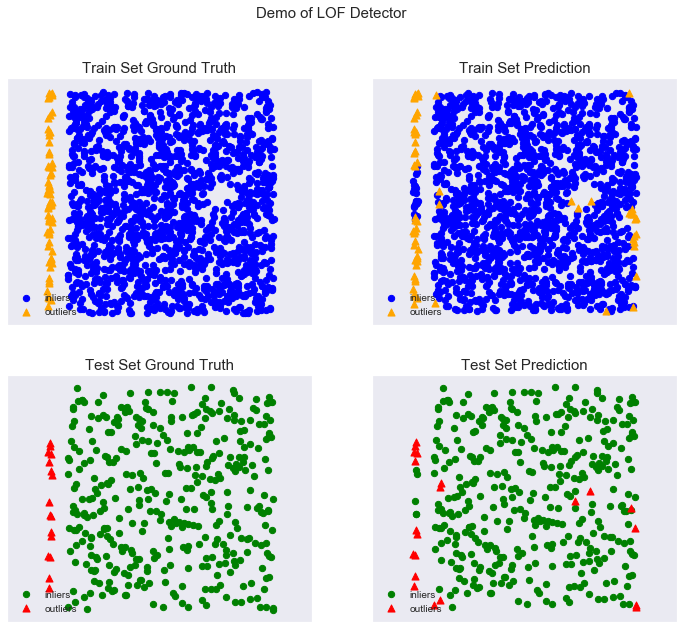

In [67]:
# train LOF detector
clf_name = 'LOF'
clf = LOF(contamination=0.04, algorithm='ball_tree', leaf_size=5, n_neighbors=30)
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

# visualize the results
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
              y_test_pred, show_figure=True, save_figure=False)

In [68]:
model_performance(y_test_pred)

Confusion Matrix: 
 [[374  10]
 [  5  11]] 

True Negative: 374
False Positive: 10
False Negative: 5
True Positive: 11 

Accuracy: 0.962
Precision: 0.524
Recall: 0.688
F_1: 0.595


### Isolation Forest